In [46]:
!pip install p3_data

In [47]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import json
from io import StringIO
import importlib

In [48]:
import p3_data
from p3_data import (glob_file_list, load_json_from_file, merge_dicts, plot_groups, 
    get_varying_column_names, filter_dataframe, take_varying_columns,
    load_json_records_as_dataframe)

In [50]:
# Load result files from P3 Test Driver
src_files = []
src_files += ['../../no_netty_comparison/manual_tests_no_netty/*.json']
src_files += ['../../no_netty_comparison/data/p3_test_driver/results/*.json']
raw_df = load_json_records_as_dataframe(src=src_files, ignore_error=True)

Loading records from 23 files...


In [51]:
# Clean raw results
def clean_result(result):
    try:
        r = result.copy()
        r['utc_begin'] = pd.to_datetime(r['utc_begin'], utc=True)
        r['utc_end'] = pd.to_datetime(r['utc_end'], utc=True)
        r['git_commit'] = r['git_commit'].split(' ')[0]
        r['driverName'] = r['driver']['name']
        if r['driverName'] == 'Pulsar':
            r = merge_dicts(r, r['driver']['client']['persistence'])
        r = merge_dicts(r, r['workload'])
        del r['workload']
        r = merge_dicts(r, r['omb_results'])
        if 'ansible_vars' in r and isinstance(r['ansible_vars'], dict):
            r = merge_dicts(r, r['ansible_vars'])
        if r['driverName'] == 'Pravega':
            if 'pravegaVersion' not in r:
                r['pravegaVersion'] = '0.6.0-2361.f273314-SNAPSHOT'
            r['pravegaVersion'] = r['pravegaVersion'].replace('-SNAPSHOT','')
        for k in list(r.keys()):
            if 'Quantiles' in k:
                r[k] = pd.Series(data=[float(q) for q in r[k].keys()], index=list(r[k].values())).sort_index() / 100
            elif isinstance(r[k], list) and 'Rate' in k:
                r[k] = pd.Series(r[k])
                r['%sMean' % k] = r[k].mean()
        r['numWorkloadWorkers'] = int(r.get('numWorkers', 0))
        r['throttleEventsPerSec'] = r['producerRate']
        r['publishRateEventsPerSecMean'] = r['publishRateMean']
        r['publishRateMBPerSecMean'] = r['publishRateMean'] * r['messageSize'] * 1e-6
        r['publishLatencyMsAvg'] = r['aggregatedPublishLatencyAvg']
        r['publishLatencyMs50Pct'] = r['aggregatedPublishLatency50pct']
        r['publishLatencyMs99Pct'] = r['aggregatedPublishLatency99pct']
        r['endToEndLatencyMsAvg'] = r['aggregatedEndToEndLatencyAvg']
        r['endToEndLatencyMs50Pct'] = r['aggregatedEndToEndLatency50pct']
        r['endToEndLatencyMs99Pct'] = r['aggregatedEndToEndLatency99pct']
        return pd.Series(r)
    except Exception as e:
        print('ERROR: %s: %s' % (r['test_uuid'], e))
        # raise e

In [52]:
# r = clean_result(raw_df.iloc[-1])
# pd.DataFrame(r)

In [53]:
clean_df = raw_df.apply(clean_result, axis=1)
clean_df = clean_df.set_index('test_uuid', drop=False)
clean_df = clean_df[clean_df.error==False]
clean_df = clean_df.sort_values(['utc_begin'])

ERROR: 1a5511b0-265c-4089-9255-e01e5bf1a24a: 'float' object is not iterable
ERROR: 5731b314-8711-440c-aa9a-1e4725b47225: 'float' object is not iterable
ERROR: feb6f7f3-6201-4855-b0d3-9ff0a77cc78e: 'float' object is not iterable


In [54]:
# Show list of columns
clean_df.columns.values

array(['ansible', 'ansible_vars', 'aws-ec2', 'build', 'command_timed_out',
       'docker', 'driver', 'elapsed_sec', 'error', 'errors', 'exit_code',
       'git_commit', 'kubernetes', 'localWorker', 'max_test_attempts',
       'noop', 'numWorkers', 'omb_results', 'omb_workers', 'output',
       'print_output', 'record_utc', 'record_uuid', 'result_filename',
       'run_as_test', 'sequence_in_test_batch', 'size_of_test_batch',
       'ssh_host', 'ssh_identity_file', 'ssh_user', 'status_html',
       'tarball', 'terraform', 'terraform_show', 'test', 'test_attempt',
       'test_batch_uuid', 'test_desc', 'test_driver_log_filename',
       'test_driver_version', 'test_uuid', 'undeploy', 'utc_begin',
       'utc_end', 'loaded_filename', 'driverName',
       'consumerBacklogSizeGB', 'consumerPerSubscription',
       'keyDistributor', 'messageSize', 'name', 'partitionsPerTopic',
       'payloadFile', 'producerRate', 'producersPerTopic',
       'subscriptionsPerTopic', 'testDurationMinutes', '

In [55]:
# Define columns that identify test parameters
param_cols = [
    'numWorkloadWorkers',
    'topics',
    'partitionsPerTopic',
    'producersPerTopic',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'testDurationMinutes',
    'keyDistributor',
    'git_commit',
    'pravegaVersion',
]

In [56]:
# Define columns that are the output of the experiments
output_cols = [
    'publishRateEventsPerSecMean',
    'publishRateMBPerSecMean',
    'publishLatencyMs50Pct',
    'publishLatencyMs99Pct',
    'endToEndLatencyMs50Pct',
    'endToEndLatencyMs99Pct',
    'utc_begin',    
]

In [57]:
cols = param_cols + output_cols

In [58]:
# View most recent results
clean_df[cols].tail(3).T

test_uuid,e851ef06-a2f8-46f7-ba1e-8899129e8a2e,693570e5-a9ec-4942-b2c4-2b6937c43d4b,42d051a1-ec17-4bb0-ac1e-9a573c7e1deb
numWorkloadWorkers,2,2,2
topics,1,1,1
partitionsPerTopic,1,1,1
producersPerTopic,1,1,1
subscriptionsPerTopic,1,1,1
consumerPerSubscription,1,1,1
testDurationMinutes,1,1,1
keyDistributor,NO_KEY,NO_KEY,NO_KEY
git_commit,22e4b5f,22e4b5f,22e4b5f
pravegaVersion,0.8.0-2508.30406cf,0.8.0-2508.30406cf,0.8.0-2508.30406cf


In [59]:
# Export to CSV
#clean_df[cols].to_csv('openmessaging-benchmark-results.csv')

In [60]:
# df = clean_df[cols]
# df = df.sort_values(['messageSize','numWorkloadWorkers','producersPerTopic','throttleEventsPerSec','utc_begin'])
# df.head()

In [82]:
# View distinct values of pravegaVersion and test counts
clean_df.groupby(['pravegaVersion']).size()

pravegaVersion
0.8.0-2508.30406cf    14
dtype: int64

In [80]:
# First level of filtering
filt_df = filter_dataframe(
    clean_df,
  #  driverName='Pravega',
  #  pravegaVersion='0.8.0-2508.30406cf',
#     pravegaVersion='0.6.0-2386.23b7340',
   # numWorkloadWorkers=2, 
    topics=1,
    testDurationMinutes=1,
   # size_of_test_batch=(2,1000), # between
   # aggregatedEndToEndLatency50pct=(1,1e6),
)
# filt_df = filt_df[filt_df.size_of_test_batch > 1]
len(filt_df)

14

In [64]:
def latency_vs_throughput_table(df):
    result_df = (df
        .set_index(['publishRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Publish Throughput (MB/s)'
    return result_df

In [65]:
def plot_latency_vs_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    plot_df = latency_vs_throughput_table(df)
    title = 'Message Size %d' % (messageSize)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

## Message Size 100 B

In [66]:
filt_100_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producersPerTopic=1,
    partitionsPerTopic=1,
)

In [67]:
# View varying columns
take_varying_columns(filt_100_df[filt_100_df.producerRate==100000]).T

test_uuid,0aa106a1-67f0-4e42-acd4-6528faf54f3f


In [68]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_100_df[param_cols].drop_duplicates().T

test_uuid,6bd8004e-aa3c-4800-9dc3-679a5d78be49
numWorkloadWorkers,2
topics,1
partitionsPerTopic,1
producersPerTopic,1
subscriptionsPerTopic,1
consumerPerSubscription,1
testDurationMinutes,1
keyDistributor,NO_KEY
git_commit,22e4b5f
pravegaVersion,0.8.0-2508.30406cf


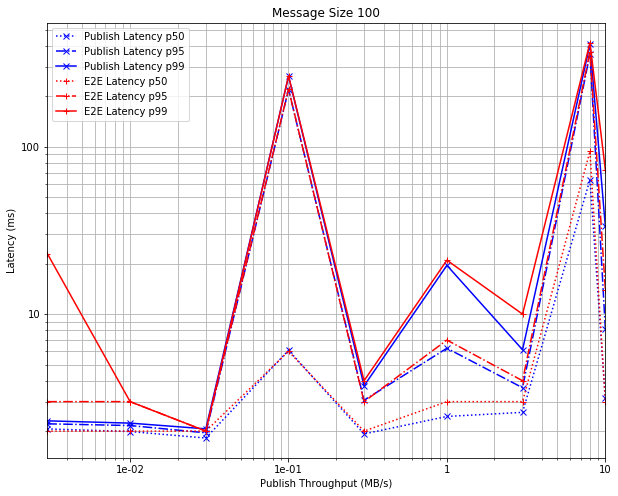

In [69]:
plot_latency_vs_throughput(filt_100_df)

In [70]:
latency_vs_throughput_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Publish Throughput (MB/s),,,,,,,
0.003007,2.061,2.211,2.303,2.0,3.000,23.000,6bd8004e-aa3c-4800-9dc3-679a5d78be49
0.010019,1.988,2.159,2.232,2.0,3.000,3.000,5773dca8-8069-4f65-a7fc-cbf91b7ce537
0.030117,1.818,1.953,2.063,2.0,2.000,2.000,8ebcfad8-3c0c-4328-b2dc-cf036ba6902f
0.100246,6.081,219.977,263.981,6.0,221.000,265.001,45d470f1-ad7d-4530-b4c7-9000121c6f35
0.300447,1.924,3.055,3.729,2.0,3.000,4.000,590eacf4-59a5-46f2-8992-e86a4acd84e1
1.002076,2.447,6.255,19.563,3.0,7.000,21.000,3943af88-1ef3-4d79-bbad-94bf1f4094e0
3.009279,2.588,3.632,6.124,3.0,4.000,10.000,fbd9d0d5-b9a1-44f3-8a57-666abb0f105b
8.016885,63.595,358.571,410.445,94.0,370.001,419.001,ba36eba1-f98e-41fa-b8f5-67f71c42a9fb
10.023827,3.146,8.200,33.466,3.0,14.000,73.000,0aa106a1-67f0-4e42-acd4-6528faf54f3f


## Message Size 10 KB

In [71]:
filt_10000_df = filter_dataframe(
    filt_df,
    messageSize=10000,
)

In [72]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_10000_df[param_cols].drop_duplicates().T

test_uuid,8437c0b5-1609-41bc-854a-9c5c6531ff4f
numWorkloadWorkers,2
topics,1
partitionsPerTopic,1
producersPerTopic,1
subscriptionsPerTopic,1
consumerPerSubscription,1
testDurationMinutes,1
keyDistributor,NO_KEY
git_commit,22e4b5f
pravegaVersion,0.8.0-2508.30406cf


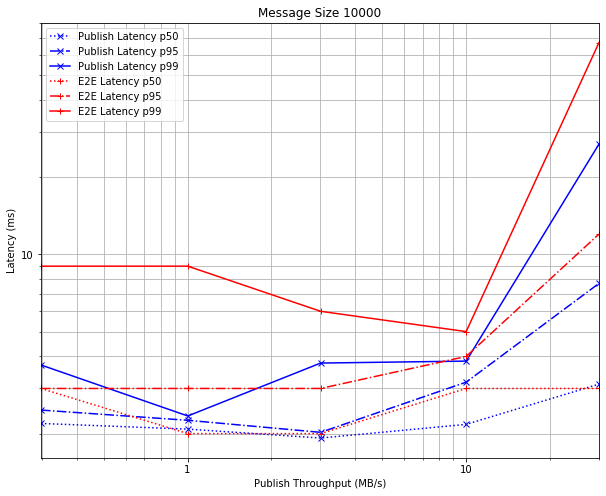

In [73]:
plot_latency_vs_throughput(filt_10000_df)

In [74]:
latency_vs_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Publish Throughput (MB/s),,,,,,,
0.297382,2.191,2.471,3.705,3.0,3.0,9.0,8437c0b5-1609-41bc-854a-9c5c6531ff4f
1.002098,2.082,2.254,2.343,2.0,3.0,9.0,d8d2a1c0-a7d8-462a-b086-066c45e8b5bd
3.007114,1.922,2.023,3.769,2.0,3.0,6.0,e851ef06-a2f8-46f7-ba1e-8899129e8a2e
10.023000,2.173,3.175,3.836,3.0,4.0,5.0,693570e5-a9ec-4942-b2c4-2b6937c43d4b
30.066639,3.119,7.708,26.934,3.0,12.0,67.0,42d051a1-ec17-4bb0-ac1e-9a573c7e1deb


## Analyze 100 B events, 50,000 events/sec, various number of partitions and producers

In [75]:
filt_50000eps_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producerRate=-1,
).sort_values(['endToEndLatencyMs99Pct'], ascending=True)
len(filt_50000eps_df)

filter_dataframe: No matching records after filtering on producerRate=[-1]


0

In [20]:
take_varying_columns(filt_50000eps_df[cols]).head(20)

NameError: name 'filt_50000eps_df' is not defined

# Analyze Latency Distribution

In [21]:
test_uuid = filt_50000eps_df.iloc[0].name
test_uuid

NameError: name 'filt_50000eps_df' is not defined

In [22]:
df = clean_df
t = df[df.test_uuid==test_uuid].iloc[0]

NameError: name 'clean_df' is not defined

In [23]:
# Cumulative Distribution Function
pubcdf = t.aggregatedPublishLatencyQuantiles
pubcdf.name = 'Publish Latency CDF'

NameError: name 't' is not defined

In [24]:
# Probability Distribution Function (latency histogram)
pubpdf = pd.Series(index=pubcdf.index, data=np.gradient(pubcdf, pubcdf.index.values), name='Publish Latency PDF')

NameError: name 'pubcdf' is not defined

NameError: name 'pubpdf' is not defined

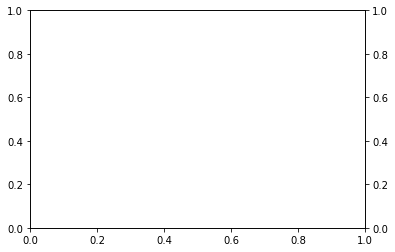

In [25]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
pubpdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='Publish Latency PDF and CDF')
pubcdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('Publish Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [ ]:
# Cumulative Distribution Function
e2ecdf = t.aggregatedEndToEndLatencyQuantiles
e2ecdf.name = 'E2E Latency CDF'
# Probability Distribution Function (latency histogram)
e2epdf = pd.Series(index=e2ecdf.index, data=np.gradient(e2ecdf, e2ecdf.index.values), name='E2E Latency PDF')

In [ ]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
e2epdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='E2E Latency PDF and CDF')
e2ecdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [ ]:
# Combined publish and E2E latency CDF
fig0, ax0 = plt.subplots()
xlim=[1,25]
pubcdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True, figsize=(10,8))
e2ecdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True)
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

## Compare Two Sets

In [26]:
# Common filter
filt_df = filter_dataframe(
    clean_df,
    driverName='Pravega',
    numWorkloadWorkers=4, 
    topics=1,
    testDurationMinutes=15,
    size_of_test_batch=(2,1000), # between
    aggregatedEndToEndLatency50pct=(1,1e6),
    messageSize=100,
    producersPerTopic=32,
    partitionsPerTopic=16,    
)
len(filt_df)

NameError: name 'clean_df' is not defined

In [27]:
# Set 1
filt1_df = filter_dataframe(
    filt_df,
    pravegaVersion='0.6.0-2361.f273314',
)
len(filt1_df)

NameError: name 'filt_df' is not defined

In [28]:
# Set 2
filt2_df = filter_dataframe(
    filt_df,
    pravegaVersion='0.6.0-2386.23b7340',
)
len(filt2_df)

NameError: name 'filt_df' is not defined

In [29]:
dfs = [filt1_df, filt2_df]
take_varying_columns(pd.concat(dfs)[param_cols]).drop_duplicates()

NameError: name 'filt1_df' is not defined

In [30]:
def plot_latency_vs_throughput_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['publishRateMBPerSecMean']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Publish Throughput (MB/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

In [31]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['pravegaVersion'], latencyMetric='Publish')

NameError: name 'filt1_df' is not defined

In [32]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['pravegaVersion'], latencyMetric='EndToEnd')

NameError: name 'filt1_df' is not defined